In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Параметры модели

In [2]:
# periods of repetition we're going to search for
CAPSULES = np.array([1, 4, 8, 16, 32, 48, 64, 96, 128])

# time (binary coded) as additional input 
TIME_AS_INPUT_SIZE = 6

# number of voices in polyphonic sampling scheme
VOICES = 5

In [3]:
# Network Parameters
num_input = 12 + TIME_AS_INPUT_SIZE         # dimension of one input at moment
num_hidden_local = 24                     
num_hidden_aggreg = 130                     # dimension of aggregation layer
num_hidden_voicegen = 100                   # dimension of voices generation layer
num_output = 12                             # output dimension for each voice

num_hidden_decoder = 100                    # dimension of decoder LSTM
num_decoder_output = 88                     # dimension of decoder output
num_decoder_rbm_hidden = 36                 # dimension of decoder rbm hidden layer
rbm_k = 1

## Модель

In [4]:
class LatencyLSTM(nn.Module):
    def __init__(self):
        super(LatencyLSTM, self).__init__()
        
        self.lstm = nn.LSTM(num_input, num_hidden_local*len(CAPSULES))
    
    def init_hidden(self, batch_size, history_init=None):
        self.t = 0
        self.hidden = []
        for latency in CAPSULES:
            self.hidden.append([(Variable(torch.zeros(1, batch_size, num_hidden_local)),
                                 Variable(torch.zeros(1, batch_size, num_hidden_local))) for _ in range(latency)])
    
    def forward(self, x):
        hidden_inputs = []
        memory_inputs = []
        for hidden in self.hidden:
            capsule_hidden = hidden[self.t % len(hidden)]
            hidden_inputs.append(capsule_hidden[0])
            memory_inputs.append(capsule_hidden[1])
        
        x, new_hidden = self.lstm(x, (torch.cat(hidden_inputs, dim=2), torch.cat(memory_inputs, dim=2)))
        
        for i in range(len(CAPSULES)):
            self.hidden[i][self.t % len(self.hidden[i])] = (new_hidden[0][:,:,i*num_hidden_local:(i+1)*num_hidden_local],
                                                            new_hidden[1][:,:,i*num_hidden_local:(i+1)*num_hidden_local])
        
        self.t = self.t + 1
        
        return x

In [5]:
class PolyphonySampler(nn.Module):
    def __init__(self):
        super(PolyphonySampler, self).__init__()
        
        self.lstm = nn.LSTM(num_hidden_aggreg + 2*num_output, num_hidden_voicegen)
        self.linear = nn.Linear(num_hidden_voicegen, 2*num_output)
        
    def init_hidden(self, batch_size):        
        self.hidden = []
        for i in range(VOICES):
            self.hidden.append((Variable(torch.zeros(1, batch_size, num_hidden_voicegen)),
                                Variable(torch.zeros(1, batch_size, num_hidden_voicegen))))
    
    def forward(self, x, next_x=None):
        sampled_notes = torch.zeros(1, x.size()[1], num_output)        
        sample_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_sample_p = Variable(torch.ones(1, x.size()[1], num_output))
                                
        banned_notes = torch.zeros(1, x.size()[1], num_output)       
        ban_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_ban_p = Variable(torch.ones(1, x.size()[1], num_output))
        
        self.voice_distributions = []
        self.voice_decisions = []
        
        for i in range(VOICES):
            all_input = torch.cat([x, Variable(sampled_notes), Variable(banned_notes)], dim=2)
            out, self.hidden[i] = self.lstm(all_input, self.hidden[i])
            out = self.linear(out)            
            
            coeff = (1 - torch.cat([sampled_notes, sampled_notes], dim=2)) * \
                    (1 - torch.cat([banned_notes, banned_notes], dim=2))
            out = Variable(coeff) * torch.exp(out)                       
            out = out / out.sum(2)[:,:,None]
            
            self.voice_distributions.append(out.data[0].numpy())
            
            sample_p = sample_p + neg_sample_p * out[:,:,:num_output]
            neg_sample_p = neg_sample_p * (1 - out[:,:,:num_output])
                             
            ban_p = ban_p + neg_ban_p * out[:,:,num_output:]
            neg_ban_p = neg_ban_p * (1 - out[:,:,num_output:])
            
            sample = torch.LongTensor(x.size()[1], 2*num_output).zero_()
            sample.scatter_(1, torch.multinomial(out.squeeze(0).data, 1), 1)
            
            self.voice_decisions.append(sample.numpy())
            
            if self.training:
                sample = torch.cat([(sample[:,:num_output] + sample[:,num_output:]) * next_x,
                                    (sample[:,:num_output] + sample[:,num_output:]) * (1 - next_x)], dim=1)
            
            sampled_notes[0] += sample[:,:num_output].float()
            banned_notes[0]  += sample[:,num_output:].float()
        
        return sampled_notes, sample_p*(1 - ban_p)

In [6]:
import itertools
def time_generator():
    times = [np.array(t) for t in itertools.product([0, 1], repeat=TIME_AS_INPUT_SIZE)]
    t = 0
    
    while True:
        yield torch.FloatTensor(times[t])
        t = (t + 1) % len(times)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.latency_lstm = LatencyLSTM()
        self.aggregation_lstm = nn.LSTM(num_hidden_local * len(CAPSULES), num_hidden_aggreg)
        self.sampler = PolyphonySampler()
        
        self.init_hidden(1)
        
    def init_hidden(self, batch_size): 
        self.timer = time_generator()
        
        self.latency_lstm.init_hidden(batch_size)
        
        self.aggreg_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_aggreg)),
                             Variable(torch.zeros(1, batch_size, num_hidden_aggreg)))
        
        self.sampler.init_hidden(batch_size)
    
    def forward(self, x, next_x=None):            
        inp = torch.cat([x, Variable(self.timer.__next__())[None, None].repeat(1, x.size()[1], 1)], dim=2)
        
        out = self.latency_lstm(inp)        
        out, self.aggreg_hidden = self.aggregation_lstm(out, self.aggreg_hidden)
        
        return self.sampler(out, next_x)

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.lstm = nn.LSTM(num_output + num_decoder_output, num_hidden_decoder)  
        self.velocity_linear = nn.Linear(num_hidden_decoder, num_decoder_output)   
        self.v_bias_linear = nn.Linear(num_hidden_decoder, num_decoder_output) 
        self.h_bias_linear = nn.Linear(num_hidden_decoder, num_decoder_rbm_hidden)      
        
        self.W = nn.Parameter(torch.randn(num_decoder_rbm_hidden, num_decoder_output)*1e-2) 
        
        self.init_hidden(1)
        
    def init_hidden(self, batch_size):        
        self.decoder_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_decoder)),
                               Variable(torch.zeros(1, batch_size, num_hidden_decoder)))
    
    # so it was done in one of rbm realisations...
    # seems legit, though akward.
    def sample_from_p(self, p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def free_energy(self, v, v_bias, h_bias):
        vbias_term = (v * v_bias).sum(2)
        hidden_term = (v.bmm(self.W.t()[None]) + h_bias).exp().add(1).log().sum(2)
        return (-hidden_term - vbias_term).mean()
    
    def forward(self, x, prev_x_decoded):            
        inp = torch.cat([x, prev_x_decoded], dim=2)
        
        out, self.decoder_hidden = self.lstm(inp, self.decoder_hidden) 
        
        return F.sigmoid(self.velocity_linear(out)), self.v_bias_linear(out), self.h_bias_linear(out)
    
    def sample(self, _v, v_bias, h_bias):
        v = _v
        
        for _ in range(rbm_k):
            p_h = F.sigmoid(v.bmm(self.W.t()[None]) + h_bias)
            h = self.sample_from_p(p_h)
            
            p_v = F.sigmoid(h.bmm(self.W[None]) + v_bias)
            v = self.sample_from_p(p_v)
        return v, p_v

In [9]:
def learn(model, decoder, batch_x, batch_decoded, optimizer, decoder_optimizer):
        
    model.init_hidden(batch_x.shape[1])
    decoder.init_hidden(batch_x.shape[1])
    
    model.train()
    decoder.train()
    optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_x = Variable(torch.FloatTensor(batch_x))
    batch_binary_decoded = Variable(torch.FloatTensor((batch_decoded > 0).astype(np.float32)))
    batch_decoded = Variable(torch.FloatTensor(batch_decoded))
    
    basic_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_output)).zero_()
    decoder_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_decoder_output)).zero_()
    velocity = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_decoder_output)).zero_()
    voice_distributions, voice_decisions = [], []
    decoder_loss = Variable(torch.FloatTensor(1).zero_())
    
    for t in range(len(batch_x)-1):        
        _, basic_p[t] = model(batch_x[t][None], batch_x[t+1].data.long())
        
        velocity[t], v_bias, h_bias = decoder(batch_x[t + 1][None], batch_decoded[t][None])
        
        v = batch_binary_decoded[t+1][None]
        v1, vp = decoder.sample(v, v_bias, h_bias)
        decoder_p[t] = vp[0]
        v1 *= batch_x[t+1][None].repeat(1, 1, 1 + num_decoder_output // num_output)[:,:,:num_decoder_output]
        decoder_loss += decoder.free_energy(v, v_bias, h_bias) - decoder.free_energy(v1, v_bias, h_bias)
        
        voice_distributions.append(model.sampler.voice_distributions)
        voice_decisions.append(model.sampler.voice_decisions)
        
    loss = -(batch_x[1:] * torch.log(basic_p) + (1 - batch_x[1:])*torch.log(1 - basic_p))
    loss_picture = loss.data.numpy()
    velocity_loss = batch_binary_decoded[1:] * (velocity - batch_decoded[1:] / 128)**2
    
    loss.sum(dim=2).mean().backward()
    (decoder_loss / (batch_x.shape[0] - 1) + velocity_loss.mean()).backward()
    
    optimizer.step()
    decoder_optimizer.step()
   
    return loss_picture, decoder_p.data.numpy(), velocity.data.numpy(), np.array(voice_distributions), np.array(voice_decisions)
        
def sample(model, decoder, start, decoder_start, time_limit):
    model.init_hidden(1)
    decoder.init_hidden(1)
    model.eval()
    decoder.eval()
    
    sample = [start[0]]
    decoded_sample = [decoder_start[0]]
    
    for t in range(len(start)-1):
        inp = Variable(torch.FloatTensor(start[t])[None, None])
        next_notes, _ = model(inp)
        
        decoder_inp = Variable(torch.FloatTensor(start[t+1])[None, None]), \
                      Variable(torch.FloatTensor(decoder_start[t+1])[None, None])
        decoder(*decoder_inp)
        
        sample.append(start[t+1])
        decoded_sample.append(decoder_start[t+1])
    
    next_notes = torch.FloatTensor(start[-1][None, None])
    
    while len(sample) < time_limit:
        next_notes, _ = model(Variable(next_notes))
        
        prev_decoded = Variable(torch.FloatTensor((decoded_sample[-1] > 0).astype(np.float32))[None, None])
        velocity, v_bias, h_bias = decoder(Variable(next_notes), prev_decoded)
        next_decoded, _ = decoder.sample(prev_decoded, v_bias, h_bias)
        
        sample.append(next_notes[0][0].numpy())
        
        mask = np.tile(sample[-1], (1 + num_decoder_output // num_output))[:num_decoder_output]
        velocity = velocity[0][0].data.numpy()
        velocity[np.logical_not(mask * next_decoded[0][0].data.numpy())] = 0
        decoded_sample.append((128*velocity).astype(int))
        
    return np.array(sample), np.array(decoded_sample).astype(int)

## Данные

In [10]:
songs = np.load("CP_dataset.npy")#np.append(np.load("Greats1_dataset.npy"),np.load("Greats2_dataset.npy"))

In [11]:
batch_size = 140
fragment_lentgh = 256
fragment_step = 32

In [12]:
def compress(song):    
    compressed = song[:, :12]
    for i in range(1,7):
        compressed = np.logical_or(compressed, song[:, 12*i:12*i+12])            
    return compressed

In [13]:
song_fragments = []
csong_fragments = []

for song in songs:
    csong = compress(song)
    
    for i in range(0, csong.shape[0] - fragment_lentgh, fragment_step):
        song_fragments.append(song[i:i+fragment_lentgh])
        csong_fragments.append(csong[i:i+fragment_lentgh])

song_fragments = np.array(song_fragments)
csong_fragments = np.array(csong_fragments)

In [14]:
def batchGenerator():
    while True:
        indexes = np.random.choice(np.arange(len(csong_fragments)), batch_size)
        batch_x, batch_decoded = csong_fragments[indexes], song_fragments[indexes]
                
        to_roll = np.random.randint(-6, 6)
        if to_roll > 0:
            batch_decoded[:, :, -to_roll:] = 0
        else:
            batch_decoded[:, :, :-to_roll] = 0

        batch_x = np.roll(batch_x, to_roll, axis=2)
        batch_decoded = np.roll(batch_decoded, to_roll, axis=2)
        
        yield np.moveaxis(batch_x, 1, 0).astype(np.float32), \
              np.moveaxis(batch_decoded, 1, 0).astype(np.float32)

### Графика

In [15]:
def drawNotes(song, name="", scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(name)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

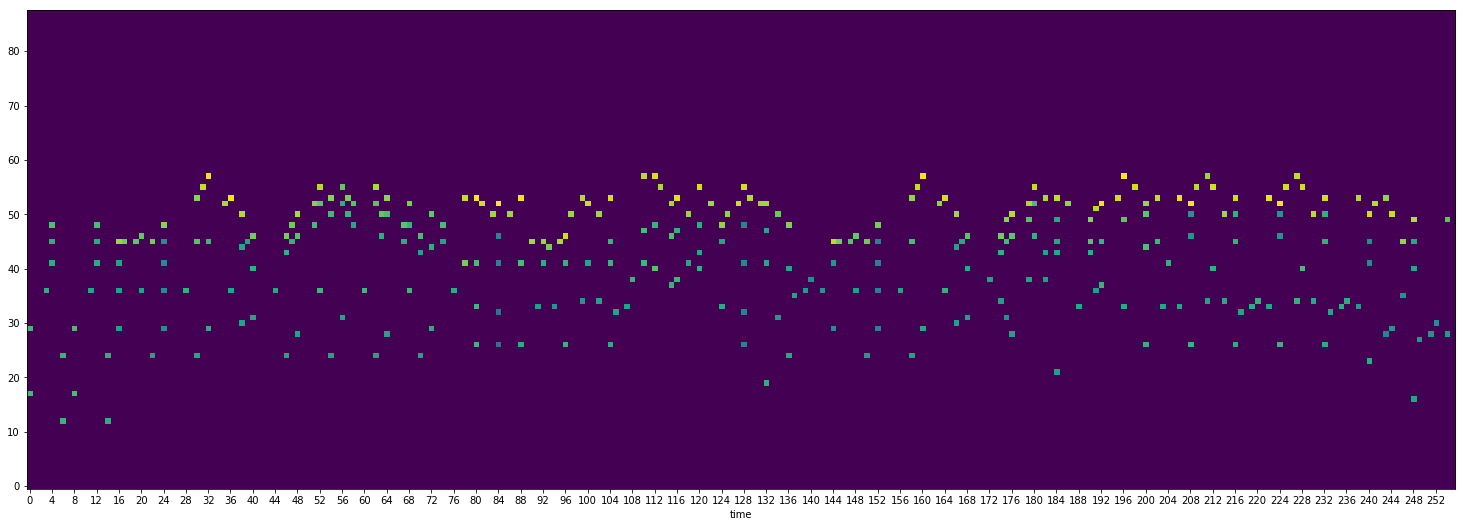

In [16]:
drawNotes(song_fragments[0])

# Обучение

In [44]:
model = Model()
decoder = Decoder()

In [48]:
model.load_state_dict(torch.load("capsules one-layer CP - model.pt"))
decoder.load_state_dict(torch.load("capsules one-layer CP - decoder.pt"))

In [42]:
losses = []
decoder_losses = []

0.117625


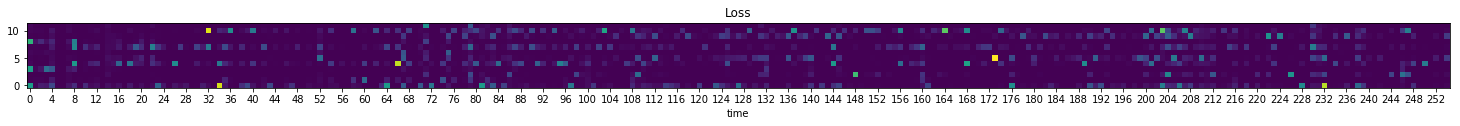

0.11144


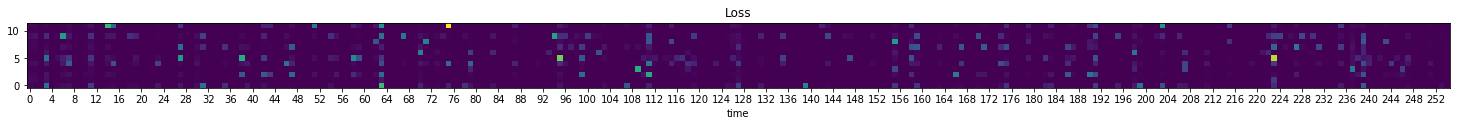

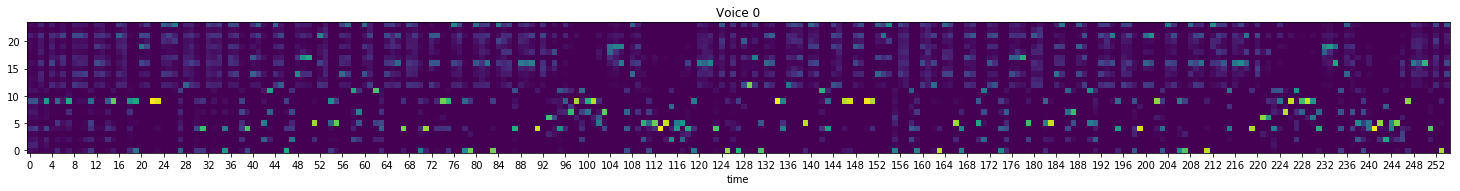

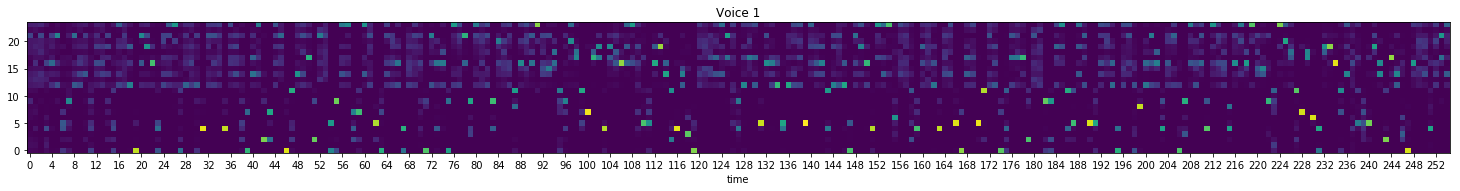

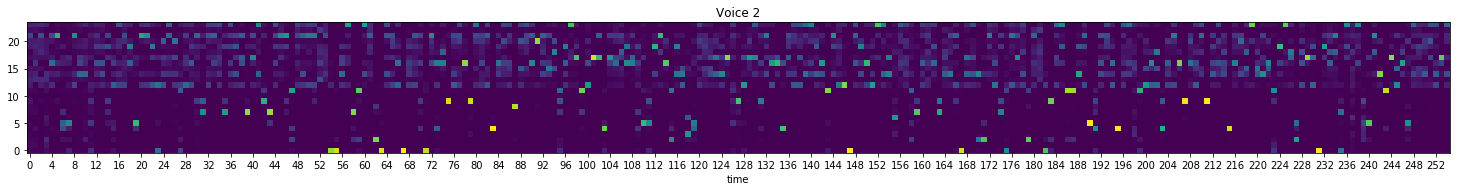

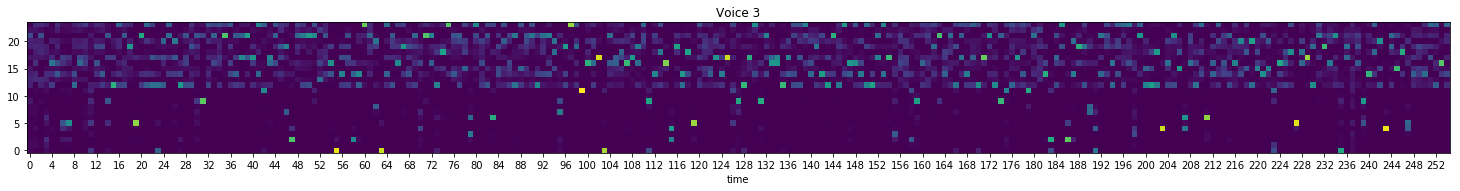

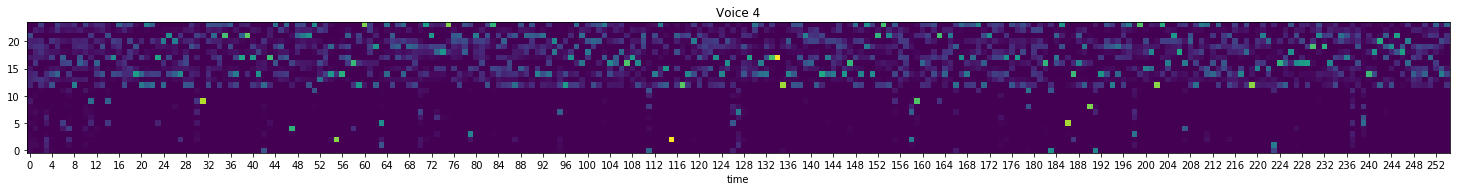

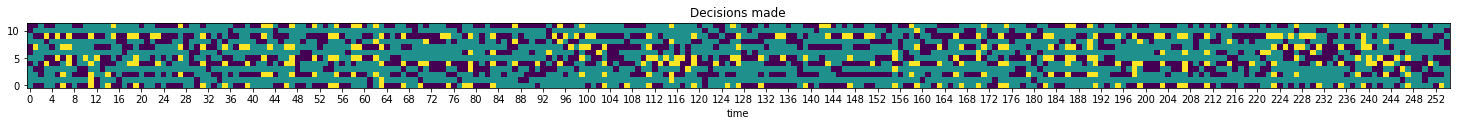

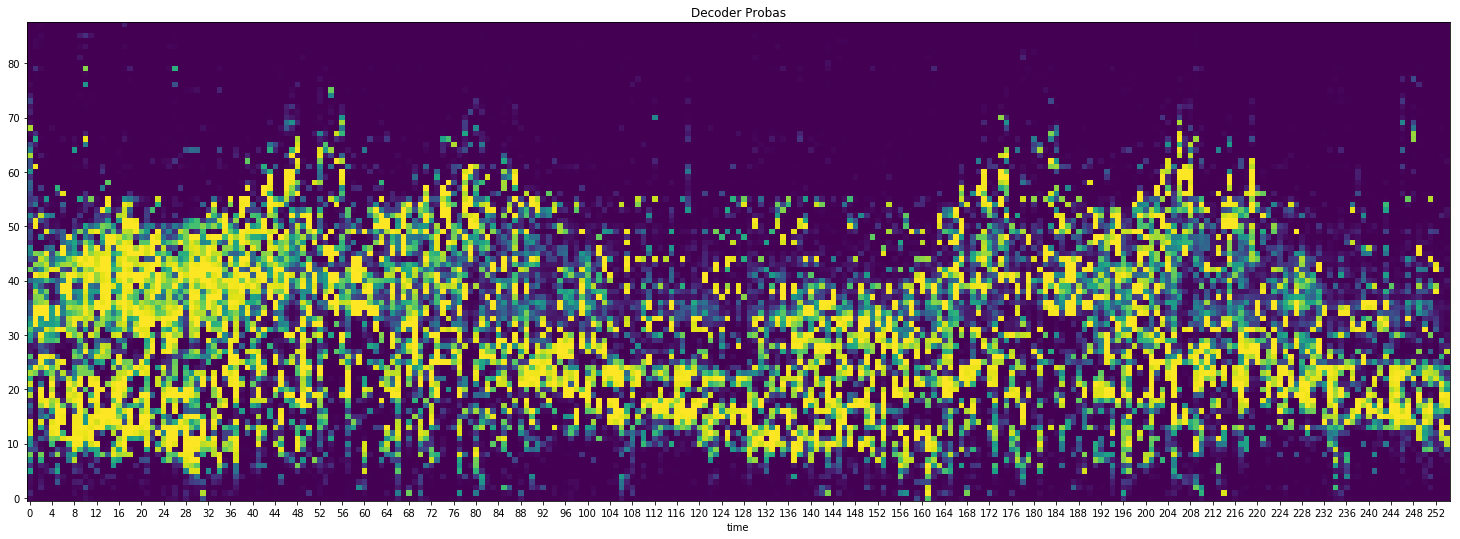

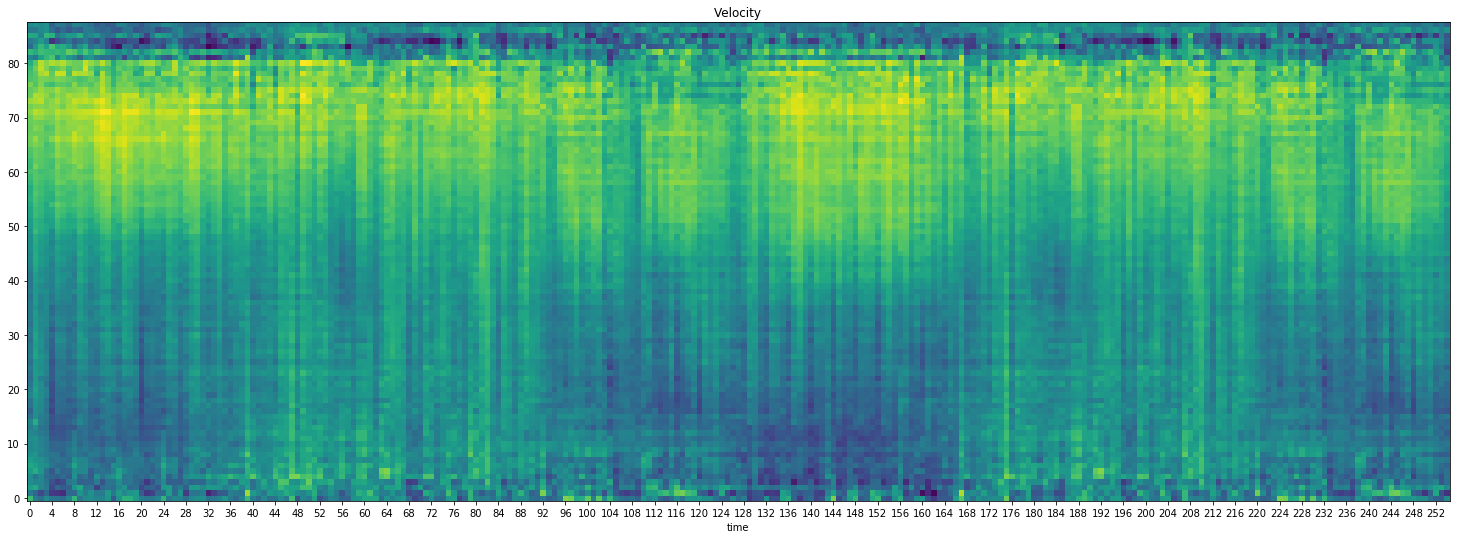

RuntimeError: invalid argument 2: invalid multinomial distribution (encountering probability entry < 0) at c:\anaconda2\conda-bld\pytorch_1519496000060\work\torch\lib\th\generic/THTensorRandom.c:281

In [46]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

for batch_x, batch_decoded in batchGenerator():
    
    loss, decoder_p, velocity, voice_probas, voice_decisions = \
        learn(model, decoder, batch_x, batch_decoded, optimizer, decoder_optimizer)
           
    if len(losses) % 25 == 0:
        print(loss.mean())
        drawNotes(loss[:, 0], "Loss")
        
        if len(losses) % 100 == 0:
            decisions = np.zeros_like(voice_decisions[:, 0, 0, :12])
            for i in range(VOICES):
                drawNotes(voice_probas[:, i, 0], "Voice " + str(i))
                decisions += voice_decisions[:, i, 0, :12]
                decisions -= voice_decisions[:, i, 0, 12:]
            
            drawNotes(decisions, "Decisions made")
            
            drawNotes(decoder_p[:, 0], "Decoder Probas")
            
            drawNotes(velocity[:, 0], "Velocity")
            
            if not loss.mean() is None:
                torch.save(model.state_dict(), "capsules one-layer CP - model.pt")
            if not decoder_p.mean() is None:
                torch.save(decoder.state_dict(), "capsules one-layer CP - decoder.pt")
        
    losses.append(loss.mean())
    #decoder_losses.append(decoder_loss.mean())  чё это?!?

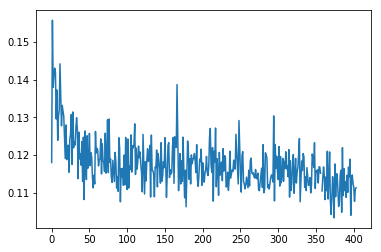

In [47]:
plt.plot(losses)
#plt.ylim([0.14, 0.19])

## Юзаем

In [49]:
from songs import *

In [62]:
n = np.random.randint(0, len(songs))
cgen, gen = sample(model, decoder, compress(songs[n][:16]).astype(np.float32), songs[n][:16].astype(np.float32), 256)

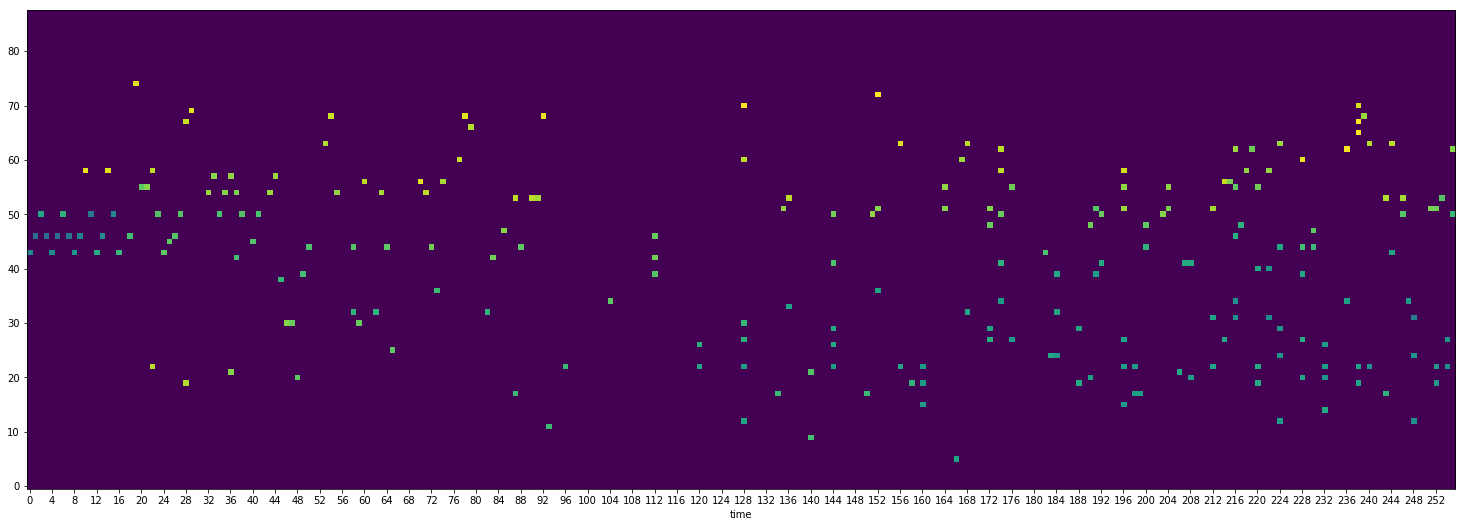

In [63]:
drawNotes(gen)

In [64]:
Song(gen, finished=True).play()

In [95]:
Song(gen, finished=True).save_file("latency lstm one-layer good example")

### производство часа музыки

In [110]:
final_ans = np.zeros((0, 88))
for _ in range(120):
    n = np.random.randint(0, len(songs))
    _, gen = sample(model, decoder, compress(songs[n][:16]).astype(np.float32), songs[n][:16].astype(np.float32), 256)
    
    final_ans = np.vstack([final_ans, gen[16:], np.zeros((24, 88))])

In [112]:
final_ans = final_ans[:28760]

In [113]:
Song(final_ans, finished=True).save_file("Model with RBM decoder 1h")